# Boosting
Data : adult.csv            
Target : income            
feature :
Preprocess :
- missing value : simple imputer with constant
- one hot encoding : reletionship, race, sex
- binary encoding : workclass, marital status, occupation, native country
- ordinal encoding : education
- no treatment : numerical
- out : fnlwgt

Random state 10, data splitting 70:30
1. Tree : model tree, max depth 3, compute precision recall f1 in test set then compute feature importances and show the tree
2. Adaboost : tree adaptive boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
3. gbc : gradient boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
4. xgb : extreme gradient boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
5. Model selection using grid search (tree, tree adaboost, gbc, xgb) optimized by f1 and using stratified CV 5 fold
6. Hyperparameter tuning the winner (optimize B L and max depth) optimized by f1 and using stratified CV 5 fold
7. Evaluate the tuned model in test set precision, recall, f1 score, ROC, PRC, and compare the result (before after)

> ## Library

In [1]:
!pip install xgboost

In [2]:
!pip install category_encoders

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model selection and metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

# library model 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

> ## Data

In [4]:
df_adult = pd.read_csv(r'C:\Users\user\Documents\Data Science\MODUL 3\What Is Ensemble_\adult.csv')
df_adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [5]:
df_adult.replace('?', np.nan, inplace = True)

In [6]:
df_adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

> ## Preprocessing Scenario

Preprocess :
- missing value : simple imputer with constant
- one hot encoding : reletionship, race, sex
- binary encoding : workclass, marital status, occupation, native country
- ordinal encoding : education
- no treatment : numerical
- out : fnlwgt

In [7]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC')),
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('onehot',OneHotEncoder(drop = 'first'),['relationship','race','sex']),
                                 ('binary',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
                                ], remainder = 'passthrough')

> ## Data Splitting

In [8]:
x = df_adult.drop(columns = ['fnlwgt','income','education'])
y = np.where(df_adult['income']=='>50K',1,0)

In [9]:
x_trainval, x_test, y_trainval, y_test = train_test_split(
    x,
    y,
    stratify = y, 
    random_state = 10,
    test_size = 0.3
)

> ## Data Transformation

In [10]:
x_trainval_prep = transformer.fit_transform(x_trainval)
x_test_prep = transformer.transform(x_test)

C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [11]:
x_trainval_prep = pd.DataFrame(x_trainval_prep)
x_test_prep = pd.DataFrame(x_test_prep)

In [12]:
onehot_feature = list(transformer.transformers_[0][1].get_feature_names())

In [13]:
binary_feature = list(transformer.transformers_[1][1]['binary encoder'].get_feature_names())

In [14]:
features = onehot_feature + binary_feature + ['age','education.num','capital.gain','capital.loss','hours.per.week']
x_trainval_prep.columns = features
x_test_prep.columns = features

> ## Model
1. Tree : model tree, max depth 3, compute precision recall f1 in test set then compute feature importances and show the tree
2. Adaboost : tree adaptive boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
3. gbc : gradient boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
4. xgb : extreme gradient boosting (max depth 3, n estimator(B) 200, learning rate 0.1) and compute precision, recall, f1 in test set then compute the feature importances)
5. Model selection using grid search (tree, tree adaboost, gbc, xgb) optimized by f1 and using stratified CV 5 fold
6. Hyperparameter tuning the winner (optimize B L and max depth) optimized by f1 and using stratified CV 5 fold
7. Evaluate the tuned model in test set precision, recall, f1 score, ROC, PRC, and compare the result (before after)

In [15]:
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(x_trainval_prep, y_trainval)

DecisionTreeClassifier(max_depth=3)

In [16]:
y_pred = tree.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7417
           1       0.74      0.52      0.61      2352

    accuracy                           0.84      9769
   macro avg       0.80      0.73      0.76      9769
weighted avg       0.83      0.84      0.83      9769



In [17]:
def modeling_result(models):
    models.fit(x_trainval_prep, y_trainval)
    
    y_pred = models.predict(x_test_prep)
    print(classification_report(y_test, y_pred))
    
    fi = models.feature_importances_
    
    imp_table = pd.DataFrame({
        'imp':fi
    }, index = features)
    
    imp_table.sort_values(by = 'imp').plot(kind = 'barh', figsize = (12,12))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7417
           1       0.74      0.52      0.61      2352

    accuracy                           0.84      9769
   macro avg       0.80      0.73      0.76      9769
weighted avg       0.83      0.84      0.83      9769



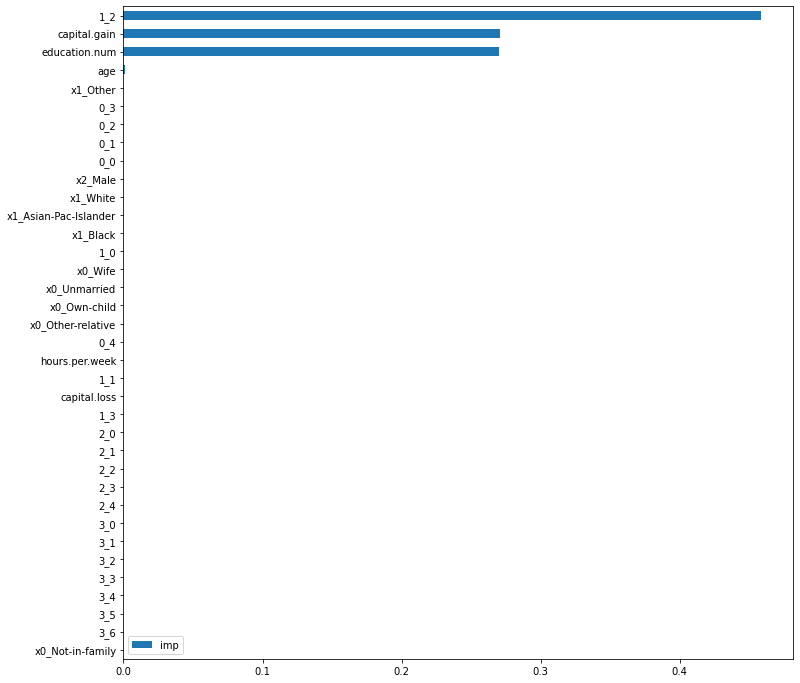

In [18]:
modeling_result(tree)

> ## Adaptive Boosting

In [19]:
tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(tree,
                             n_estimators = 200,
                             learning_rate = 0.1,\
                             random_state = 10)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7417
           1       0.78      0.64      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



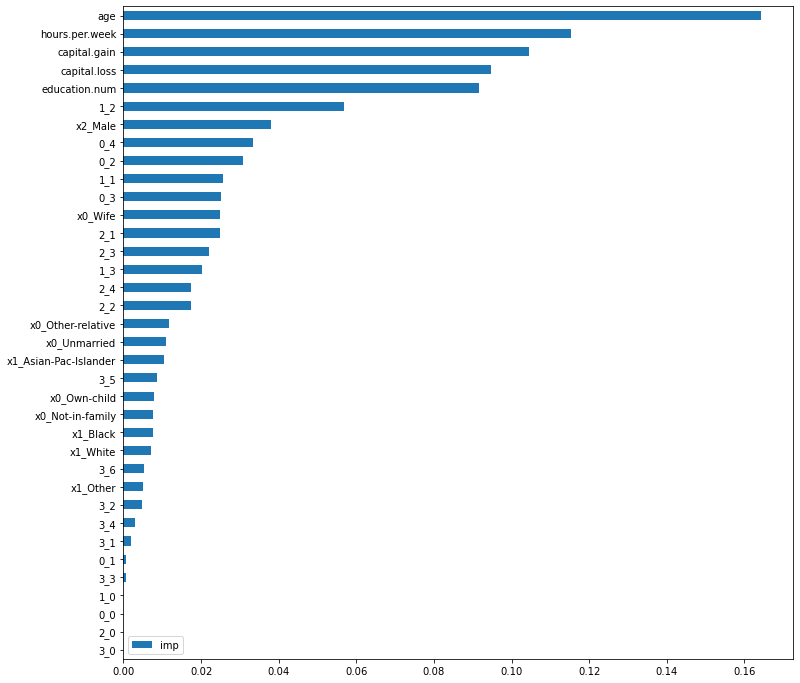

In [20]:
modeling_result(tree_ada)

> ## Gradient Boosting

In [21]:
model_gbc = GradientBoostingClassifier(n_estimators = 200,
                                       learning_rate = 0.1,
                                       max_depth = 3,
                                       random_state = 10
                                      )

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7417
           1       0.79      0.63      0.70      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



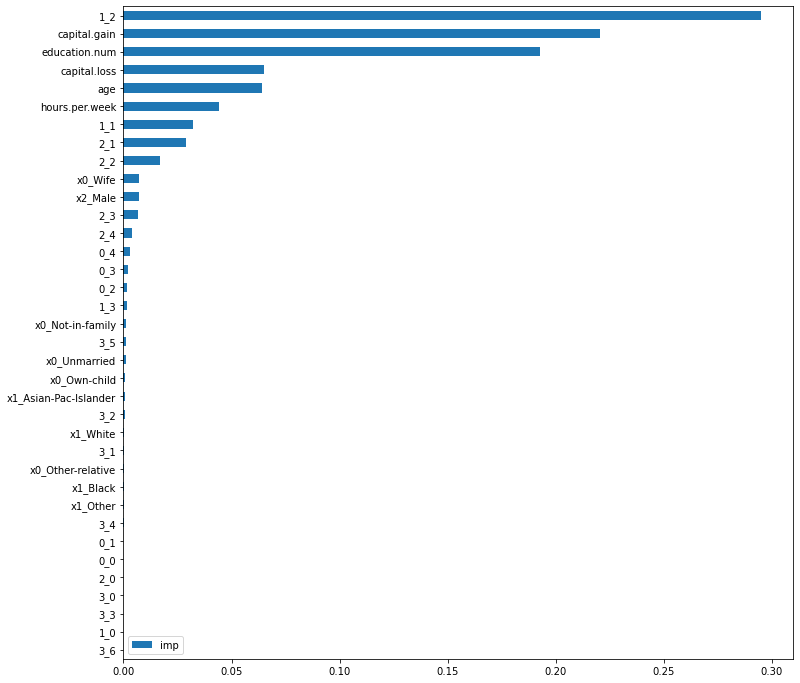

In [22]:
modeling_result(model_gbc)

> ## XG Boost

In [23]:
model_xgb = XGBClassifier(n_estimators = 200,
                         learning_rate = 0.1,
                         max_depth = 3,
                         random_state = 10)

C:\Users\user\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7417
           1       0.78      0.63      0.70      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



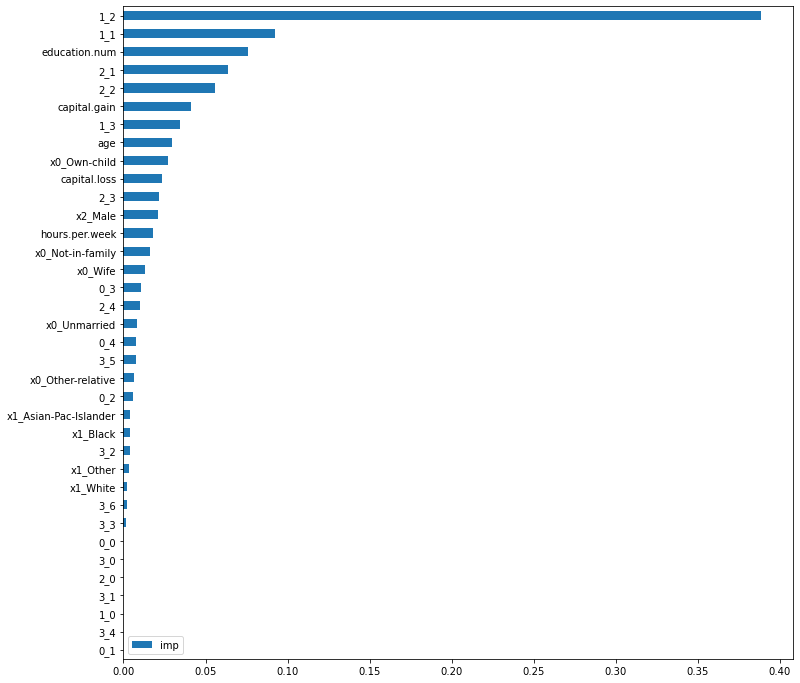

In [24]:
modeling_result(model_xgb)

> ## Model Selection

In [25]:
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(x_trainval_prep, y_trainval)

tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(tree,
                             n_estimators = 200,
                             learning_rate = 0.1,\
                             random_state = 10)

model_gbc = GradientBoostingClassifier(n_estimators = 200,
                                       learning_rate = 0.1,
                                       max_depth = 3,
                                       random_state = 10
                                      )

model_xgb = XGBClassifier(n_estimators = 200,
                         learning_rate = 0.1,
                         max_depth = 3,
                         random_state = 10)

estimator = Pipeline([
                      ('preprocess', transformer),
                      ('clf', tree)                 
])

hyperparam_space = {
    'clf':[tree, tree_ada, model_gbc, model_xgb]
}

skfold = StratifiedKFold(n_splits = 5)

grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skfold, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [26]:
grid_search.fit(x_trainval, y_trainval)

C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                                       

In [27]:
print('best score', grid_search.best_score_)
print('best param', grid_search.best_params_)

best score 0.7077803071345716
best param {'clf': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}


In [28]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,52.906550,2.241729,1.178338,0.388184,AdaBoostClassifier(base_estimator=DecisionTree...,{'clf': AdaBoostClassifier(base_estimator=Deci...,0.695085,0.711376,0.708229,0.704409,0.719802,0.707780,0.008126,1
3,14.842130,1.369800,0.093543,0.004535,"XGBClassifier(base_score=None, booster=None, c...","{'clf': XGBClassifier(base_score=None, booster...",0.687148,0.701613,0.696093,0.692229,0.712000,0.697817,0.008527,2
2,38.692833,11.315634,0.155301,0.099537,"GradientBoostingClassifier(n_estimators=200, r...",{'clf': GradientBoostingClassifier(n_estimator...,0.683700,0.702920,0.699647,0.691837,0.708081,0.697237,0.008580,3
0,0.478515,0.099253,0.084353,0.021191,DecisionTreeClassifier(max_depth=3),{'clf': DecisionTreeClassifier(max_depth=3)},0.622812,0.611790,0.589716,0.604997,0.617021,0.609267,0.011406,4


> ## Hyperpamater Adaptive Boosting

In [29]:
tree = DecisionTreeClassifier(max_depth = 3)
tree_ada = AdaBoostClassifier(tree,
                             n_estimators = 200,
                             learning_rate = 0.1,\
                             random_state = 10)

estimator = Pipeline([
                      ('preprocess', transformer),
                      ('clf', tree_ada)                 
])

skfold = StratifiedKFold(n_splits = 5)

hyperparam_space = {
    'clf__learning_rate':[0.1, 0.05, 0.2],
    'clf__n_estimators':[200, 300, 400],
    'clf__base_estimator__max_depth':[2, 3, 5]
} # 27 combinations

tune_ada = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skfold, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [30]:
print(estimator.get_params().keys()) # to get hyperparam key

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'clf', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__onehot', 'preprocess__binary', 'preprocess__onehot__categories', 'preprocess__onehot__drop', 'preprocess__onehot__dtype', 'preprocess__onehot__handle_unknown', 'preprocess__onehot__sparse', 'preprocess__binary__memory', 'preprocess__binary__steps', 'preprocess__binary__verbose', 'preprocess__binary__imputer', 'preprocess__binary__binary encoder', 'preprocess__binary__imputer__add_indicator', 'preprocess__binary__imputer__copy', 'preprocess__binary__imputer__fill_value', 'preprocess__binary__imputer__missing_values', 'preprocess__binary__imputer__strategy', 'preprocess__binary__imputer__verbose', 'preprocess__binary__binary encoder__cols', 'preprocess__binary__binary encoder__drop_invariant', 'preprocess__binary__binary encoder__handle_missing', 'prep

In [31]:
tune_ada.fit(x_trainval, y_trainval)

C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                                       

In [32]:
print('best score', tune_ada.best_score_)
print('best param', tune_ada.best_params_)

best score 0.7089215571159596
best param {'clf__base_estimator__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__n_estimators': 400}


In [33]:
pd.DataFrame(tune_ada.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__base_estimator__max_depth,param_clf__learning_rate,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,81.403559,1.264551,2.092201,0.271979,3,0.1,400,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.696171,0.711264,0.703557,0.706700,0.726916,0.708922,0.010252,1
17,110.881829,3.584496,2.620184,0.278885,3,0.2,400,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.697628,0.714146,0.708984,0.697512,0.723114,0.708277,0.009842,2
16,85.232047,1.711371,2.188053,0.181347,3,0.2,300,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.700050,0.709519,0.707209,0.701337,0.721760,0.707975,0.007744,3
10,56.984712,6.327173,1.527511,0.287838,3,0.1,300,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.692765,0.713861,0.703133,0.706879,0.722714,0.707870,0.010078,4
9,40.399139,4.879348,0.986760,0.181050,3,0.1,200,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.695085,0.711376,0.708229,0.704409,0.719802,0.707780,0.008126,5
14,109.264897,1.611959,2.628704,0.206679,3,0.05,400,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.696133,0.710736,0.707646,0.700554,0.720988,0.707211,0.008596,6
15,57.442083,0.873821,1.349410,0.115950,3,0.2,200,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.698020,0.709486,0.706231,0.702244,0.719446,0.707086,0.007279,7
13,62.511683,8.083513,2.127979,0.389966,3,0.05,300,"{'clf__base_estimator__max_depth': 3, 'clf__le...",0.695344,0.707585,0.704523,0.698783,0.712792,0.703805,0.006203,8
8,65.905041,6.475554,2.100581,0.286008,2,0.2,400,"{'clf__base_estimator__max_depth': 2, 'clf__le...",0.687344,0.711730,0.708105,0.697137,0.714073,0.703678,0.010021,9
7,53.895702,3.176031,1.848502,0.483298,2,0.2,300,"{'clf__base_estimator__max_depth': 2, 'clf__le...",0.688574,0.708167,0.709710,0.698832,0.711797,0.703416,0.008645,10


> ## Before After

In [36]:
best_model = tune_ada.best_estimator_
best_model.fit(x_trainval, y_trainval)

C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                                                   BinaryEncoder())]),
                                                  ['w

In [37]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7417
           1       0.78      0.65      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7417
           1       0.78      0.64      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



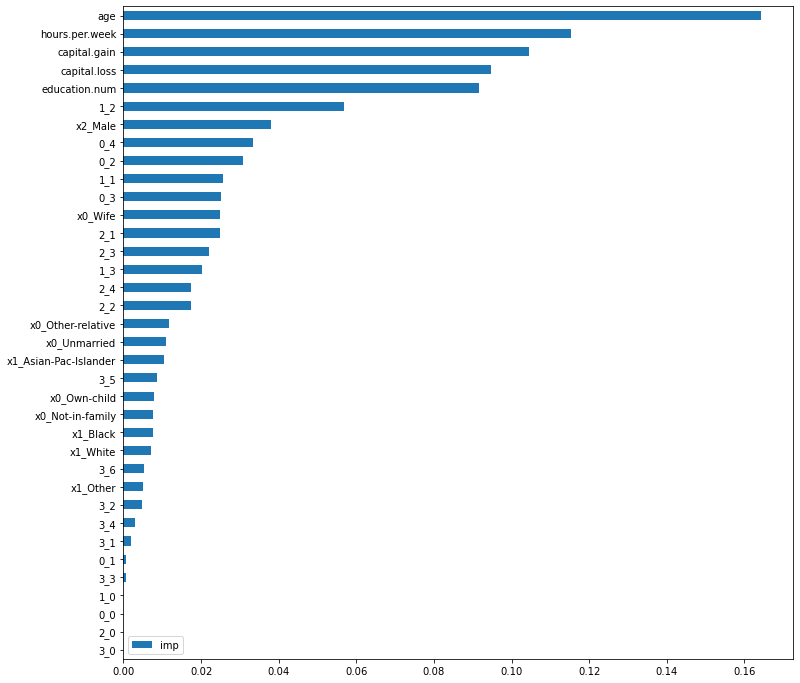

In [34]:
modeling_result(tree_ada)

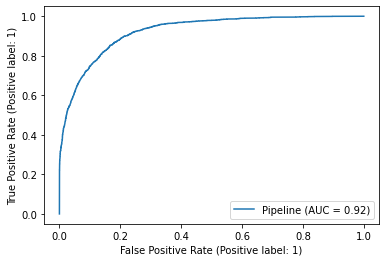

In [38]:
plot_roc_curve(best_model, x_test, y_test)

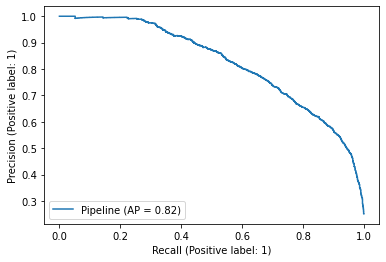

In [39]:
plot_precision_recall_curve(best_model, x_test, y_test)